## Overview
This is the Jupyter Notebook for the Georgia Tech ESRI Albany Hub Analytics and Visualization Project.  This version of the notebook incorporates a program analysis to quantify changes in energy use in Albany, GA among participants of HUD-funded programs. The first part implements matching algorithms that reduce observable bias in order to compare participants and non-participants.  The second part includes ArcGIS interactive visuals supplementing the analysis.  The visuals are intended to be used by cities to interpret results with spatial information.  


The code here takes performance data from HUD-funded properties and compares them to properties that do not receive HUD funding but have been matched on similar attributes.  The matching attributes include variables such as baseline energy consumption prior to receiving HUD funding, property size in square feet, number of bedrooms, number of batherooms, year built, market value, and assessment value.  To validate the effectiveness of the matching procedures, the code also calculates the reductions in standardize bias for each of the matching variables with results shown before and after matching.  After a suitable matching model is selected, the code then estimates the energy savings by a difference-in-differences regression and also includes time dummies to control for seasonal trends in annual energy use.  
 

### Files Needed
Two files are needed to utilize this code. The first file contains information about the properties before the treatment period used for matching. The second file needed is a panel dataset that contains the time-varying variables such as energy use during the pre- and post-treatment period. The records linkage between files is done with the AddressID field which indicates the unit of analysis is at the property level.

### User Authentication
In order to engage with the full interactive visuals generated by the code, an active ArcGIS account is necessary to establish a connection to the server.  You will be prompted to enter your password when creating the ArcGIS items from your data files.


### Data Dictionary
These attributes are the variables we identified as indicitive of whether or not a house would receive HUD funding. Outlined below are the units and format we had our data in to begin with to ensure correct execution of the code. 

 - "Baseline" - Average household baseline energy consumption (kWh/square foot)
 - "Size" - Area of the property (sqaure foot)
 - "Beds" - Number of bedrooms in the house (integer)
 - "Baths" - Number of bathrooms in the house (integer)
 - "YearBuilt" - Year the house was built (date)
 - "Market" - Market value of the home (dollars)
 - "Assessment" - Assessed value of the property (dollars)
 - "Group" - Binary treatment indicator that takes a value of 1 if receiving HUD funding and 0 otherwise

## Package Installation and Import

In [1]:
!pip -q install pymatch
!pip -q install linearmodels

import warnings
warnings.filterwarnings('ignore')
from pymatch.Matcher import Matcher
import pandas as pd
import numpy as np
import statistics as stat
import math
import pymatch.functions as uf
from linearmodels import PanelOLS

%matplotlib inline
import matplotlib.pyplot as plt

## Dataframe and Variable Selection
### Path Assignments (A)
1.  Assign the "matchPath" variable the file location for property data before the treatment period.

2.  Assign the "panelPath" variable the file location for the data containing time-varying variables later used to estimate treatment effects.

In [2]:
# Data locations
matchPath = "/Users/Kira/Documents/ESRI_Research_Project/OverallStats.csv"
panelPath = "/Users/Kira/Dropbox/ResidentialElectricPanelData2.csv"

# Reads in data from CSV files to create respective data frames
matchDF = pd.read_csv(matchPath)
panelDF = pd.read_csv(panelPath)

### Field Assignments (B)
1. In the "fields" list, insert column headers from the "matchDF" indicating the factors that are likely to influence the probablity a unit is receiving HUD funding.
2. In the "fields2" list, insert column headers from the "matchDF" for non-matching fields to integrate into the analysis other than those influencing the probability of receiving funding.
3. In the "dependent" list, insert a column header from the "panelDF" identifying the dependent variable you want to measure the effects of.
4. In the "independent" list,  insert column headers from the "panelDF" identifying the time and treatment group dummy variables.

In [3]:
# (B1) List of matching attributes 
fields = \
[
    "Baseline",
    "Size",
    "Beds",
    "Baths",
    "YearBuilt",
    "Market",
    "Assessment",
    "Group"
 ]

# (B2) List of additional non-matching fields to be integrated into the analysis 
fields2 = \
[
    "Project",
    "Program",
    "AddressID",
    "Index",
    "Premise",
    "Address"
]

# (B3) Dependent variable 
dependent = \
[
    "NormConsumption"
]

# (B4) List of dummy variables
independent = \
[
    "Post",
    "Post_Group",
    "Year_2005",
    "Year_2006",
    "Year_2007",
    "Year_2008",
    "Year_2009",
    "Year_2010",
    "Year_2011",
    "Year_2012",
    "Year_2013",
    "Year_2014",
    "Year_2015",
    "Year_2016",
    "Year_2017",
    "Year_2018",
    "Year_2019"
]

## Matching

### Preparing Test and Control Data (C)
1. Assign the "new_index" variable the column header of the "matchDF" index for easy merging later.
2. Index "cov_data" by equating the variable indicating whether the house is receiving funding to its respective value to separate data.
3. Assign the "y_variable" variable the column header of the variable indicating if a property is in the treatment group or not.
4. Create a Matcher object that will assign propensity scores to units indicating how likely they are to be in the treatment group.
5. Specify a random seed value for repeatable results.
6. Fit propensity scores and set parameter "nmodels" to the amount of models desired.
7. Match the data and define method of matching.
8. Define 'nmatches' which is the number of untreated houses that you'd like to be matched to the treated houses.
9. Define 'threshold' which is the absolute value of the max difference in propensity scores.

In [4]:
cov_data = matchDF[fields]
merge_data = matchDF[fields2]

# (C1) Aligning indices between data frames for easy merging
new_index = 'Index'
merge_data.set_index(new_index,inplace=True)

# (C2) Separates data into treated and non-treated groups
test = cov_data[cov_data.Group == 1]
control = cov_data[cov_data.Group == 0]

# (C3) Identifies the column indicating whether a property receives funding
y_variable = 'Group'
test[y_variable] = 1
control[y_variable] = 0

# (C4) Assigns propensity scores to units and returns a matching formula
m = Matcher(test, control, yvar = y_variable, exclude=[]) 

# (C5) Random number generator for easy replication
np.random.seed(20170925)

# (C6) Fits propensity scores to specified number of models
m.fit_scores(balance=True, nmodels = 100) 

# Returns score that indicates how accurately observed outcomes are replicated by model
m.predict_scores()

# (C7-C9) Matches data with replacement and places the matches into a data frame
m.match(method="min", nmatches=2, threshold=0.0001) 
m.assign_weight_vector()

Formula:
Group ~ Baseline+Size+Beds+Baths+YearBuilt+Market+Assessment
n majority: 19815
n minority: 307
Fitting Models on Balanced Samples: 100\100
Average Accuracy: 69.19%


## Preparing the Plots
### Calculating Standardized Percent Bias (D)
1. Assign "trb" and "cob" to the respective test and control columns of the m data frame before matching. 
2. Assign "tra" and "coa" to the respective test and control columns of the m.matched_data data frame after matching.
3. Calculate the standardized percent bias both before and after matching.
4. Append these calculations to the "test_results" and "test_results_after lists".

### Creating the Bias Reduction Graph (E)
1. Adjust the parameters to the graph if desired.  For example, change figsize to create a larger or smaller graph, change the color and width of the lines, and modify the names of the labels as needed.


Text(0.5, 1.0, 'PSM Bias Reduction')

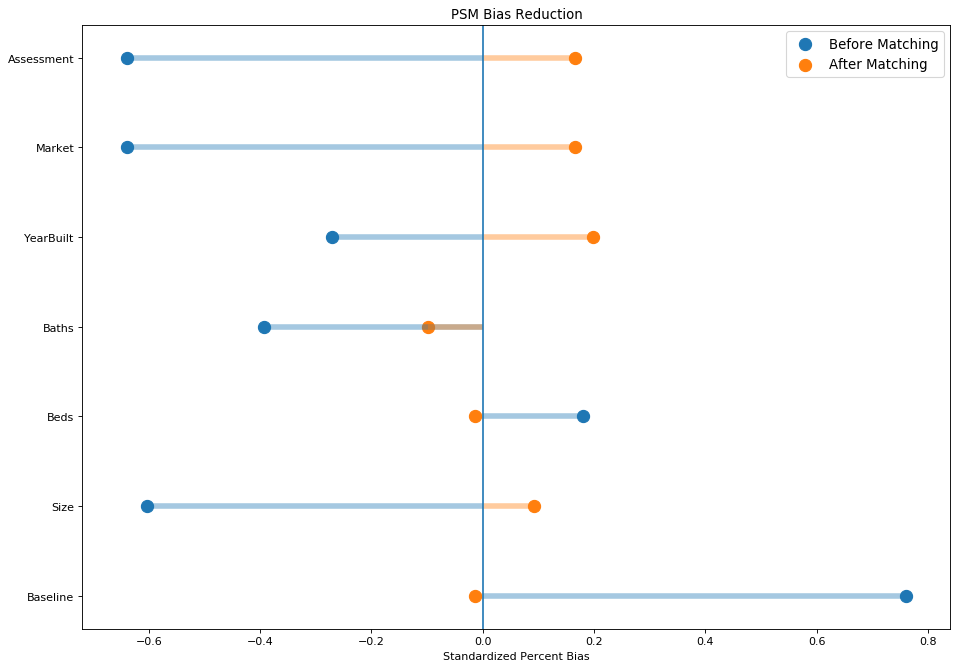

In [5]:
# Preparing data for plotting a bias graph
test_results = []
test_results_after = []
y = []

# Iterates through every matching attribute
for col in m.matched_data.columns:
    if uf.is_continuous(col,m.X) and col not in m.exclude:
        # (D1) Assign the values for the test and control group before matching
        trb, cob = m.test[col], m.control[col]
        # (D2) Assign the values for the test and control group after matching
        tra = m.matched_data[m.matched_data[m.yvar]==True][col]
        coa = m.matched_data[m.matched_data[m.yvar]==False][col]
        # (D3) Calculate the standardized percent bias before and after matching
        std_diff_mean_before = (stat.mean(trb) - stat.mean(cob))/((math.sqrt(stat.variance(trb)+stat.variance(cob)))/2)
        std_diff_mean_after = (stat.mean(tra) - stat.mean(coa))/((math.sqrt(stat.variance(tra)+stat.variance(coa)))/2)
        # (D4) Append the calculations to the lists used to plot the results 
        test_results.append(std_diff_mean_before)
        test_results_after.append(std_diff_mean_after)
        y.append(col)
    

# (E1) Plotting the bias reduction graph
plt.figure(figsize=(14,10), dpi= 80)
plt.hlines(y=y, xmin=0, xmax=[test_results], color=[m.control_color], alpha=0.4,linewidth=5)
plt.hlines(y=y, xmin=0, xmax=[test_results_after], color=[m.test_color],alpha=0.4,linewidth=5)
plt.scatter(test_results, y, s=120, color = m.control_color, label='Before Matching')
plt.scatter(test_results_after, y, s=120, color = m.test_color, label='After Matching')
plt.legend(prop={'size': 12})
plt.xlabel('Standardized Percent Bias')
plt.axvline(x=0)
plt.title('PSM Bias Reduction')

## Creating New Data Sets (F)
1. Change the 'record_id' column of 'matches_table' to add 1 to every value because record_id automatically assigns indices to houses beginning with 0.
2. Change the name to match the index column in the 'matchDF'.
3. Merge the data and on the specified index that uniquely identifies each house.
4. Create a CSV file for personal reference if desired.
5. Merge 'panelDF' with 'new_table' on a unique identifier shared between data frames.

In [6]:
matches_table = (m.matched_data.sort_values("match_id"))
# Assigns a unique value to every property matched
matches_table['ID'] = list(range(1,matches_table.shape[0]+1))
# (F1) If your 'matchDF' starts at a different value than 0, adjust record_id to reflect the same value
matches_table.record_id = matches_table.record_id + 1
# (F2) Rename the 'record_id' column to reflect the 'matchDF' index
matches_table.rename({'record_id':new_index},axis=1,inplace=True)

# (F3) Merge the data on the specified index 
new_table = pd.merge(merge_data,matches_table,on=new_index,how='right')
new_table.drop(new_table.columns[new_table.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)

# (F4) Creates a csv file for desired data
new_table.to_csv("/Users/Kira/Documents/ESRI_Research_Project/New_Table.csv",header=True,index=False)

# (F5) Merge matched data with panel data
mergeDF = pd.merge(panelDF,new_table,on='Premise',how='right')
mergeDF.drop(mergeDF.columns[mergeDF.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)
mergeDF = mergeDF.drop_duplicates(subset=['ID', 'TimePeriod'])


## Uploading Items to ArcGIS Online (G)
1. Import ArcGIS libraries to utilize various functions.
2. Enter ArcGIS account credentials to establish a connection to ArcGIS Online.
3. Assign the 'item_types' list the types of files to check to see if they already exist.
4. Assign the 'name_list' list the names of files to check to see if they already exist.
5. Assign the 'csv_file_list' list the paths of the files to add to the ArcGIS Online platform.
6. Set titles and tags for the first CSV file.
7. Add the first CSV file as a CSV item on ArcGIS Online.
8. Use the first CSV item to publish a Feature Layer mapping data points using coordinates on ArcGIS online.



In [7]:
# (G1) Import the GIS class to create a connection to ArcGIS Online.
from arcgis.gis import GIS
from IPython.display import display
from arcgis.mapping import WebMap
from IPython.display import IFrame
import getpass
import os

# (G2) Enter ArcGIS Online credentials
username = "kohare6_albgis"
password = getpass.getpass("Enter password: ")
gis = GIS("https://www.arcgis.com", username, password)

# Method that deletes existing files for smooth importation of new files
def delete_existing_items(item_types, name_list):
    for current_item_type in item_types:
        for file_name in name_list:    
            search_result = gis.content.search(query=file_name, item_type=current_item_type)
            if len(search_result) > 0:
                for item in search_result:
                    item.delete()
                    print("Deleted existing " + current_item_type + ": ", item)

# (G3) Specify types of items to check for
item_types = ["CSV", "Feature Layer Collection"]
# (G4) Specify names of items to check for
name_list = ["Treated Houses","Baseline Consumption","PSM1"]
delete_existing_items(item_types, name_list)


# (G5) CSV files to add to ArcGIS Online platform
csv_file_list = \
[
    "/Users/Kira/Documents/ESRI_Research_Project/Treatment1.csv",
    "/Users/Kira/Documents/ESRI_Research_Project/OverallStats1.csv",
]

# (G6) Setting titles and tags for the CSV file detailing treated houses
treatment_properties = \
{
    'title': 'Treated Houses',
    'tags': 'albany, hud participants'
}

# (G7) Add CSV file for treated houses to ArcGIS account
treatment_csv = gis.content.add(item_properties = treatment_properties,  data = csv_file_list[0])
display(treatment_csv)
# (G8) Add a Feature Layer mapping the houses with coordinates to ArcGIS account
treatment_lyr = treatment_csv.publish()
display(treatment_lyr)


# (G6) Repeat step 6 to set titles and tags for the CSV file detailing baseline energy consumption of Albany houses
baseline_properties = \
{
    'title': 'Baseline Consumption',
    'tags': 'energy usage, albany, housing'
}

# (G7) Repeat step 7 to add CSV file for baseline energy consumption of Albany houses
baseline_csv = gis.content.add(item_properties = baseline_properties, data = csv_file_list[1])
display(baseline_csv)
# (G8) Repeat step 8 to publish a Feature Layer mapping the houses with coordinates to ArcGIS account
baseline_lyr = baseline_csv.publish()
display(baseline_lyr)

Enter password: ········
Deleted existing CSV:  <Item title:"Treated Houses" type:CSV owner:kohare6_albgis>
Deleted existing CSV:  <Item title:"Baseline Consumption" type:CSV owner:kohare6_albgis>
Deleted existing Feature Layer Collection:  <Item title:"Treated Houses" type:Feature Layer Collection owner:kohare6_albgis>
Deleted existing Feature Layer Collection:  <Item title:"Baseline Consumption" type:Feature Layer Collection owner:kohare6_albgis>


<Item title:"Treated Houses" type:CSV owner:kohare6_albgis>

<Item title:"Treated Houses" type:Feature Layer Collection owner:kohare6_albgis>

<Item title:"Baseline Consumption" type:CSV owner:kohare6_albgis>

<Item title:"Baseline Consumption" type:Feature Layer Collection owner:kohare6_albgis>

## ArcGIS Interactive Visuals (H)
1. Search for and define existing layers on ArcGIS Online to add to the map.
2. Set the location to center the map with.
3. Set the basemap.
4. Add a layer to the map and define characteristics such as 'renderer', 'field_name', 'opacity', etc.
5. Define a dictionary to describe a renderer for a layer.
6. Add information to the renderer such as color, symbol type, label values, etc.
7. Display the map within the Jupyter Notebook.


In [8]:
# (H1) Search existing layers to add to a map
wards_lyr = gis.content.search("City Ward")[0]
beat_lyr = gis.content.search("Beat")[0]

# (H2) Set map location
map1 = gis.map('Albany, GA',zoomlevel=11)

# (H3) Set the basemap
map1.basemap = 'gray-vector'

# (H4) Add a layer to map   
map1.add_layer(wards_lyr,{'opacity':0.4})

# (H5) Define a renderer for a new layer
treatment_renderer = {'renderer':'autocast',
                      'type':'uniqueValue',
                      'field1':'Program'}

# (H6) Add information to the renderer
treatment_renderer['uniqueValueInfos'] = [{"value":"HOME",
                                          "symbol": {
                                              "color": [0,0,0,255],
                                              "size": 6,
                                              "angle":0,
                                              "xoffset":0,
                                              "yoffset":0,
                                              "type":"esriSMS",
                                              "style":"esriSMSCircle",
                                              "outline": {
                                                  "color":[255,255,255,255],
                                                  "width":0.75,
                                                  "type":"esriSLS",
                                                  "style":"esriSolid"
                                              }
                                          },
                                          "label": "HOME"
                                         },
                                         {"value": "CDBG",
                                          "symbol": {
                                              "color": [255,255,255,255],
                                              "size": 6,
                                              "angle":0,
                                              "xoffset":0,
                                              "yoffset":0,
                                              "type":"esriSMS",
                                              "style":"esriSMSCircle",
                                              "outline": {
                                                  "color":[0,0,0,255],
                                                  "width":0.75,
                                                  "type":"esriSLS",
                                                  "style":"esriSolid"
                                              }
                                          },
                                          "label":"CDBG"
                                          }]

# (H4) Repeat step 4 and add a layer to the map
map1.add_layer(treatment_lyr, {'type':'FeatureLayer',
                               'renderer':treatment_renderer,
                               'field_name':'Program',
                                'opacity':1})


# (H7) Display the map
display(map1)

MapView(layout=Layout(height='400px', width='100%'), zoom=11.0)

## Fixed Effect Panel Regression (I)
1. Set the index of 'mergeDF' to a variable unique to each entity and a time variable.
2. Assign a new column in 'mergeDF' the product of the treatment time period and the treatment group columns.
3. Build a PanelOLS model to estimate the changes observed with the dependent variable.
4. Fit the model to estimate the model parameters.

In [9]:
# (I1) Indexes by individual entity and time variables
mergeDF.set_index(['ID',"TimePeriod"],inplace=True)
# (I2) Creates a new column to reflect energy useage for houses receiving HUD funding after the treatment period
mergeDF['Post_Group'] = mergeDF['Post'] * mergeDF['Group']

# (I3) PanelOLS model to estimate the change in energy consumption
model = PanelOLS(mergeDF[dependent],mergeDF[independent],entity_effects=True,time_effects=False)
# (I4) Fit the model to estimate the model parameters
fit = model.fit(cov_type = 'clustered', cluster_entity=True,cluster_time=True)

print(fit)


print(fit.params['Post_Group'])

                          PanelOLS Estimation Summary                           
Dep. Variable:        NormConsumption   R-squared:                        0.0206
Estimator:                   PanelOLS   R-squared (Between):             -0.0780
No. Observations:              163488   R-squared (Within):               0.0206
Date:                Fri, Apr 03 2020   R-squared (Overall):             -0.0578
Time:                        10:51:46   Log-likelihood                -1.253e+05
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      200.77
Entities:                         921   P-value                           0.0000
Avg Obs:                       177.51   Distribution:               F(17,162550)
Min Obs:                       53.000                                           
Max Obs:                       186.00   F-statistic (robust):             2.8942
                            